### Interacción con la API de SoundCloud:

La API en developer.spotify.com ya no esta permitida para crear nuevas apps.
Intente Deezer y tampoco.

In [84]:
import importlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
import app

importlib.reload(app)
client_id, client_secret = app.get_credentials()


class SoundCloudClient:
    BASE_URL = "https://api.soundcloud.com"
    TOKEN_URL = "https://api.soundcloud.com/oauth2/token"

    def __init__(self, client_id_value: str, client_secret_value: str):
        if not client_id_value or not client_secret_value:
            raise ValueError("Faltan CLIENT_ID/CLIENT_SECRET en .env o .env.example.")
        self.client_id = client_id_value
        self.client_secret = client_secret_value
        self.session = requests.Session()
        self.access_token = self._get_access_token()

    def _get_access_token(self) -> str:
        data = {
            "grant_type": "client_credentials",
            "client_id": self.client_id,
            "client_secret": self.client_secret,
        }
        response = self.session.post(self.TOKEN_URL, data=data, timeout=30)
        response.raise_for_status()
        return response.json().get("access_token", "")

    def _get(self, path: str, **params):
        url = f"{self.BASE_URL}/{path.lstrip('/')}"
        headers = {"Authorization": f"OAuth {self.access_token}"} if self.access_token else {}
        response = self.session.get(url, params=params, headers=headers, timeout=30)
        response.raise_for_status()
        return response.json()

    def resolve_user_id(self, profile_url: str) -> int:
        data = self._get("resolve", url=profile_url)
        return data.get("id")

    def user_tracks(self, user_id: int, limit: int = 200):
        return self._get(f"users/{user_id}/tracks", limit=limit)


# 1) Resolver el ID del artista desde la URL
PROFILE_URL = "https://soundcloud.com/daftpunkofficialmusic"
sc = SoundCloudClient(client_id, client_secret)
ARTIST_ID = sc.resolve_user_id(PROFILE_URL)

# 2) Obtener tracks del artista
tracks_raw = sc.user_tracks(ARTIST_ID, limit=200)

# 3) Seleccionar top 10 por popularidad (playback_count) sin filtrar
tracks_top10 = sorted(tracks_raw, key=lambda t: t.get("playback_count", 0), reverse=True)[:10]

# Títulos de las 10 canciones más escuchadas
[t.get("title") for t in tracks_top10]

['Harder, Better, Faster, Stronger',
 'One More Time',
 'Around the World',
 'Get Lucky (feat. Pharrell Williams and Nile Rodgers)',
 'Instant Crush (feat. Julian Casablancas)',
 'Get Lucky (Radio Edit - feat. Pharrell Williams and Nile Rodgers)',
 'Something About Us',
 'Lose Yourself to Dance (feat. Pharrell Williams)',
 'Veridis Quo',
 'Digital Love']

In [85]:
# Tabla completa del artista en pandas
artist_df = pd.DataFrame([{
    "id": t.get("id"),
    "title": t.get("title"),
    "playback_count": t.get("playback_count", 0),
    "likes_count": t.get("likes_count", 0),
    "reposts_count": t.get("reposts_count", 0),
    "comment_count": t.get("comment_count", 0),
    "duration_min": (t.get("duration", 0) / 60000),
    "permalink_url": t.get("permalink_url"),
} for t in tracks_raw])

artist_df.head(5)

,id,title,playback_count,likes_count,reposts_count,comment_count,duration_min,permalink_url
0,1664287200,Contact (Drumless Edition),9802,0,7,48,0.5,https://soundcloud.com/daftpunkofficialmusic/c...
1,1664286708,Give Life Back to Music (Drumless Edition),10660,0,8,5,0.5,https://soundcloud.com/daftpunkofficialmusic/g...
2,1664286312,Touch (Drumless Edition) (feat. Paul Williams),6772,0,6,4,0.5,https://soundcloud.com/daftpunkofficialmusic/t...
3,1664284500,Get Lucky (Drumless Edition) (ft. Pharrell Wil...,5663,0,7,1,0.5,https://soundcloud.com/daftpunkofficialmusic/g...
4,1664284353,Instant Crush (Drumless Edition) (feat. Julian...,8661,0,10,2,0.5,https://soundcloud.com/daftpunkofficialmusic/i...


In [86]:
# 3) Quedarse con tracks (top 10) y columnas requeridas
tracks = tracks_top10

rows = [
    {
        "title": t.get("title"),
        "popularity": t.get("playback_count", 0),
        "duration_min": (t.get("duration", 0) / 60000),
    }
    for t in tracks
]

columns = ["title", "popularity", "duration_min"]
df = pd.DataFrame(rows, columns=columns)

# Imprimir títulos, popularidad y duración
if df.empty:
    print("No hay tracks con playback_count para este usuario.")
else:
    print(df[columns].to_string(index=False))

                                                            title  popularity  duration_min
                                 Harder, Better, Faster, Stronger     5208424      3.774267
                                                    One More Time     2842847      5.339867
                                                 Around the World     1709079      7.159733
             Get Lucky (feat. Pharrell Williams and Nile Rodgers)     1580061      0.500000
                         Instant Crush (feat. Julian Casablancas)      622870      0.500000
Get Lucky (Radio Edit - feat. Pharrell Williams and Nile Rodgers)      585366      0.500000
                                               Something About Us      584079      3.878317
                 Lose Yourself to Dance (feat. Pharrell Williams)      457563      0.500000
                                                      Veridis Quo      427579      5.753900
                                                     Digital Love      426029   

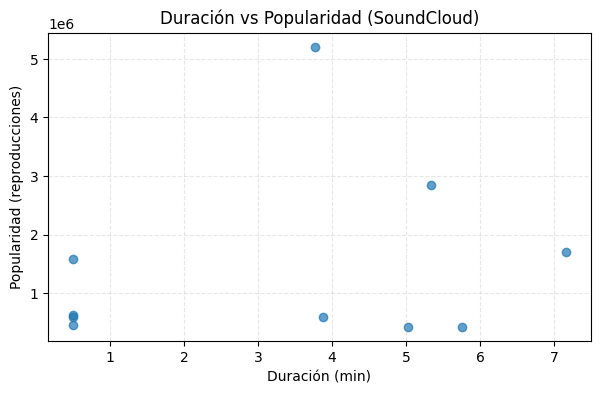

In [87]:
# 4) Scatter plot: duración vs popularidad
plt.figure(figsize=(7, 4))
plt.scatter(df["duration_min"], df["popularity"], alpha=0.7)
plt.title("Duración vs Popularidad (SoundCloud)")
plt.xlabel("Duración (min)")
plt.ylabel("Popularidad (reproducciones)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

INTERPRETACION:
- No se observa una relación clara entre la duración y la popularidad: hay canciones cortas y largas con distintos niveles de reproducciones. Por eso, una canción más corta puede ser más popular que otra más larga; Y la duración por sí sola no determina la popularidad.

Track con más reproducciones: Harder, Better, Faster, Stronger
Track con más likes: Contact (Drumless Edition)


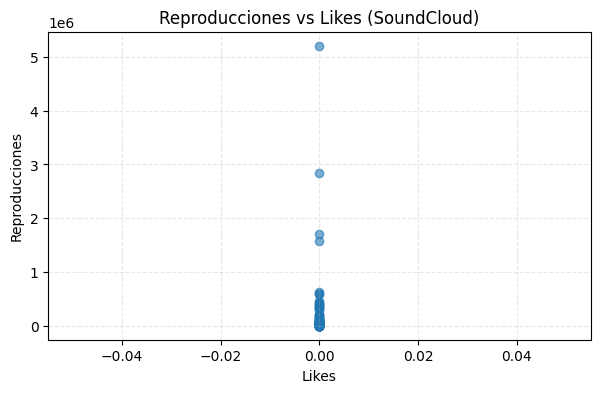

In [ ]:
# Análisis extendido:

metrics_rows = [
    {
        "title": t.get("title"),
        "playback_count": t.get("playback_count", 0),
        "likes_count": t.get("likes_count", 0),
        "reposts_count": t.get("reposts_count", 0),
        "comment_count": t.get("comment_count", 0),
        "duration_min": (t.get("duration", 0) / 60000),
    }
    for t in tracks_raw
]

metrics_df = pd.DataFrame(metrics_rows)

# Promedios:
metrics_df[[
    "playback_count",
    "likes_count",
    "reposts_count",
    "comment_count",
    "duration_min",
]].mean()

# Extremos:
max_playback = metrics_df.loc[metrics_df["playback_count"].idxmax()]
max_likes = metrics_df.loc[metrics_df["likes_count"].idxmax()]

print("Track con más reproducciones:", max_playback["title"])
print("Track con más likes:", max_likes["title"])

# Correlaciones
metrics_df[[
    "playback_count",
    "likes_count",
    "reposts_count",
    "comment_count",
    "duration_min",
]].corr()

# Gráfica sencilla: reproducciones vs likes
plt.figure(figsize=(7, 4))
plt.scatter(metrics_df["likes_count"], metrics_df["playback_count"], alpha=0.6)
plt.title("Reproducciones vs Likes (SoundCloud)")
plt.xlabel("Likes")
plt.ylabel("Reproducciones")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

CONCLUSION ADICIONAL:

1. Las reproducciones suelen superar ampliamente a likes, reposts y comentarios; la dispersión de `playback_count` es la más grande.

2. Se observa una relación positiva ligera entre `playback_count` y `likes_count`, pero no es perfecta.

3. Algunas pistas con duraciones similares muestran popularidades muy distintas, lo que sugiere que la duración no es el factor determinante.